## [E-12] 프로젝트: CIFAR-10 이미지 생성하기

> * 이미지 데이터의 shape가 (28, 28, 1)에서 (32, 32, 3)으로 변경된다. 생성자, 판별자 모델의 입출력 shape 및 모델 구조에 영향이 있다.
> * 이미지가 단색의 grayscale에서 RGB 3채널의 컬러이미지로 변경된다. 시각화 과정에서 고려할 점이 있다.
> * 입력데이터 전체 차원이 3~4배 증가하면서, 학습이 진행되는 양상이 다소 달라진다.


### 0. 작업환경 구성하기

In [ ]:
$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples
$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints
$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history

### 1. 데이터셋 구성하기

> * 학습에 사용할 train_x의 이미지를 [-1, 1]로 정규화한다.
> * 로드한 학습 데이터를 시각화를 통해 확인해 본다.
> * tf.data.Dataset 모듈의 fromtensorslices() 함수를 사용하여 미니배치 데이터셋을 구성해 본다.

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
cifar10 = tf.keras.datasets.cifar10
(train_x, _), (test_x, _) = cifar10.load_data()
train_x.shape

(50000, 32, 32, 3)

In [3]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


### 1) 정규화

In [4]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [5]:
train_x.shape

(50000, 32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


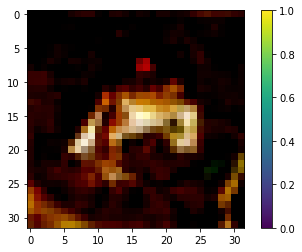

In [6]:
plt.imshow(train_x[0].reshape(32, 32, 3))
plt.colorbar()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

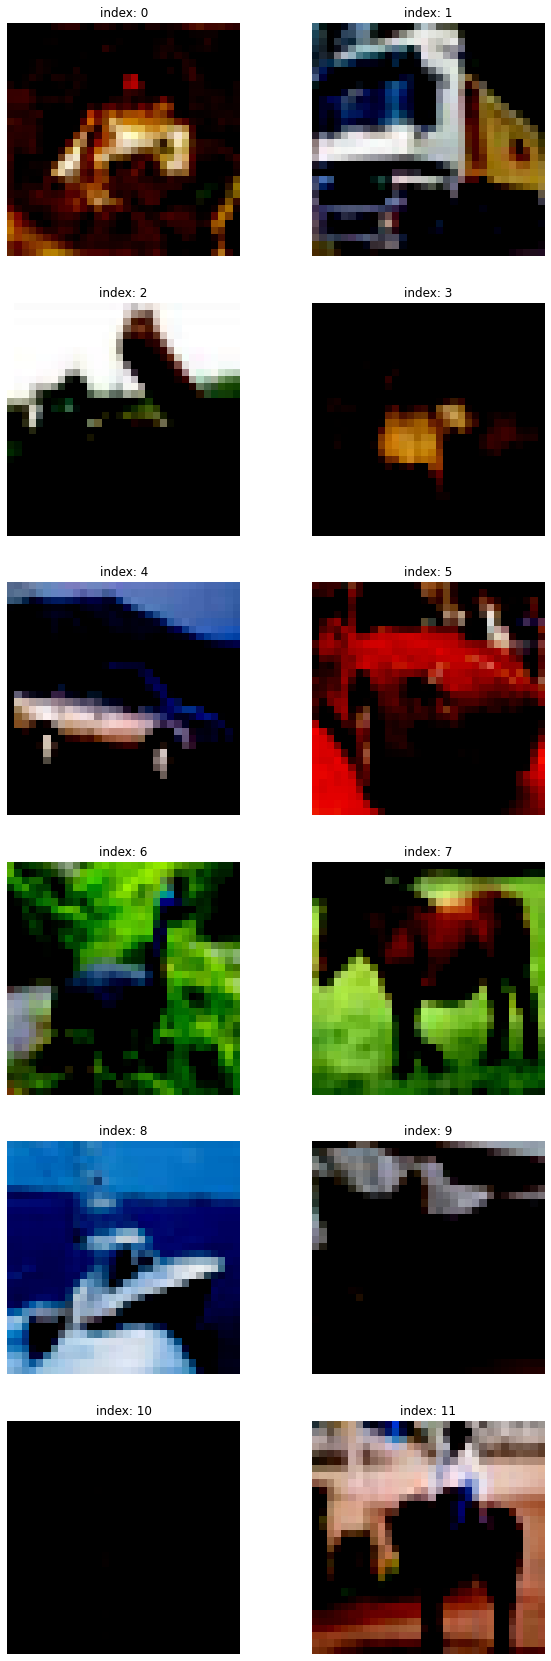

In [7]:
plt.figure(figsize=(10, 30))              # 전체 프레임 크기 결정

for i in range(12):
    plt.subplot(6, 2, i+1)                   # 여려개의 이미지 한번에 띄우기
    plt.imshow(train_x[i].reshape(32, 32, 3))
    plt.title(f'index: {i}')
    plt.axis('off')                         # 불필요한 축 삭제
plt.show()

In [8]:
BUFFER_SIZE = 50000             # 전체 데이터를 잘 섞기 위해 설정
BATCH_SIZE = 128                # 모델이 한 번에 학습할 데이터 양     

print("완료")

완료


In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print("완료")

완료


### 2. 생성자 모델 구현하기

>*  (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성한다.
> * noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성한다.
> * 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인한다.

In [10]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))           # 이미지 크기 조정
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))                       # 채널 조정

    return model
  
print("완료")

완료


생성기 모델을 개발하려면 100 차원의 잠재 공간에서 32 x 32 x 3 또는 3,072 값을 가진 2D 배열로 벡터를 변환해야한다.

In [11]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

In [12]:
import tensorflow as tf
noise = tf.random.normal([1, 100])                  # 가우시안 분포에서 랜덤으로 노이즈 벡터를 만들 수 있음

In [13]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

* 학습하는 중이 아니니 training=False를 설정해 주어야 한다. Batch Normalization 레이어는 훈련 시기와 추론(infernce) 시기의 행동이 다르기 때문에 training=False을 주어야 올바른 결과를 얻을 수 있다.
* 첫 번째 1은 1개(batch_size=1)라는 뜻을, 그 뒤로는 (32, 32, 3) 사이즈 이미지가 생성되었다는 뜻이다.

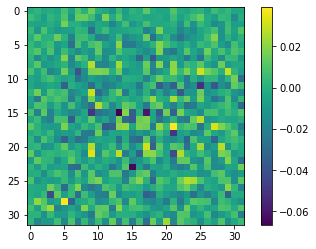

In [14]:
plt.imshow(generated_image[0, :, :, 0])            # 0번째와 3번째 축의 인덱스를 0으로 설정해서 32*32 형태로 이미지 출력
plt.colorbar()
plt.show()

### 3. 판별자 모델 구현하기

> * (32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성한다.
> * 위 STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인한다.

In [15]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())           # 3차원 이미지를 1차원으로 벡터로 변환

    # Fourth: Dense Layer
    model.add(layers.Dense(1))            # 단 하나의 값 출력
    return model

In [16]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [17]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00131848]], dtype=float32)>

### 4. 손실함수와 최적화 함수 구현하기

> * 생성자와 판별자의 손실함수(loss)를 구현한다.
> * 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현한다.
> * 생성자와 판별자를 최적화하는 optimizer를 정의한다.


**Real Image에 대한 라벨을 1**, **Fake Image에 대한 라벨을 0**으로 두었을 때, 각각의 손실함수를 이용해 정량적으로 달성해야 하는 목표하는 결과는 다음과 같다.

* 생성자 : 판별자가 Fake Image에 대해 판별한 값, 즉 D(fake_image) 값이 1에 가까워지는 것
* 판별자 : Real Image 판별값, 즉 D(real_image)는 1에, Fake Image 판별값, 즉 D(fake_image)는 0에 가까워지는 것

In [18]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)    # 인풋값 0-1사이 분포 확률값으로 가정

print("완료")

완료


이제 cross_entropy를 활용해 계산할 loss들은 fake_output와 real_output, 두 가지를 활용한다.

* fake_output : 생성자가 생성한 Fake Image를 구분자에 입력시켜서 판별된 값, 즉 D(fake_image)
* real_output : 기존에 있던 Real Image를 구분자에 입력시켜서 판별된 값, 즉 D(real_image)


In [19]:
def generator_loss(fake_output):                           # 생성자 손실 함수
    return cross_entropy(tf.ones_like(fake_output), fake_output)
  
print("완료")

완료


In [20]:
def discriminator_loss(real_output, fake_output):              # 판별자 손실 함수
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
  
print("완료")

완료


In [21]:
def discriminator_accuracy(real_output, fake_output):           # 판별자 정확도
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy
  
print("완료")

완료


In [22]:
generator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)       # 생성자 최적화 함수   
discriminator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)   # 판별자 최적화 함수

print("완료")

완료


* Adam 함수 또한 tf.keras.optimizers 안에 있다.중요한 하이퍼 파라미터인 "learning rate"는 0.0001로 설정할 텐데, 학습 품질을 올려보고 싶다면 여러 가지로 값을 바꾸어 가며 학습을 진행해 보는 것을 추천한다.

In [23]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])       # seed noise
seed.shape

TensorShape([16, 100])

### 5. 훈련과정 상세 기능 구현하기

> * 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현한다.    
> * 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현한다.
> * 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 구현한다.
> * training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정한다.

In [24]:
@tf.function                                         # 데코레이터
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값
  
print("완료")

완료


* @tf.function 데코레이터가 사용된 함수에 입력된 입력은 Tensorflow의 graph 노드가 될 수 있는 타입으로 자동변환된다. 

* 입력데이터: Real Image 역할을 할 images 한 세트를 입력으로 받음
* 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 noise를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성함
* tf.GradientTape()는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기
* generated_images 생성 : generator가 noise를 입력받은 후 generated_images 생성
* discriminator 판별 : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 real_output, fake_output 출력
* loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산
* accuracy 계산 : fake_output, real_output으로 discriminator가
* gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산
* 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신
* 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴


In [25]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0])
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/test/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()
    
print("완료")

완료


* train_step() 함수가 리턴하는 gen_loss, disc_loss, real_accuracy, fake_accuracy 이상 4가지 값을 history라는 dict 구조에 리스트로 저장하고 있다가 매 epoch마다 시각화하는 함수를 만든다. 예를 들어 생성자의 loss의 history는 history['gen_loss']로 접근할 수 있는 list로 관리한다.

In [26]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/test/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()
    
    
print("완료")

완료


In [27]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/test/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

print("완료")

완료


### 6. 학습 과정 진행하기

> * 위 STEP 5에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행한다.
> * 학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현한다.
> * 학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 함께 제출한다.

**참고** 

학습 과정 중 학습 epoch를 추가 진행해야 하거나, 학습한 모델을 활용하여 이미지를 생성할 필요가 생긴다. 그럴 때마다 모델 학습을 처음부터 다시 진행한다면 시간 낭비가 된다.
우리는 위에서 checkpoint 모듈을 이용해 모델을 저장해 둔 바 있습니다. 이를 이용해 학습해 둔 모델을 로드하면 모델 재학습이 필요 없이 이런 작업을 진행할 수 있다. 아래는 checkpoint 모듈을 활용하여 모델을 로드하는 예시이다.

In [28]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/test/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator



Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f49681b0b10> and <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x7f49b53aacd0>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4968154a90> and <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x7f4968179590>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7f49bd909650> and <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f49bd909ed0>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f49bd909ed0> and <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x7f49b54e9310>).

Two checkpoint references resolved to different objects (<ten

checkpoint를 통해 모델이 로드되었으면 아래 코드를 실행할 경우 로드된 모델의 파라미터 상태에서 훈련을 재개할 수도 있다. 

In [29]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)
             
print("완료")

완료


In [30]:
save_every = 10
EPOCHS = 200

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")    # 물리적인 GPU를 찾아서 list로 반환

[]

In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/cifar10/test02/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

#### 학습과정 시각화하기

In [31]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/test/cifar10_dcgan_test01.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/test/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif

-rw-r--r-- 1 aiffel-dj23 aiffel-dj23 3738801  3월  1 22:35 /home/aiffel-dj23/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif


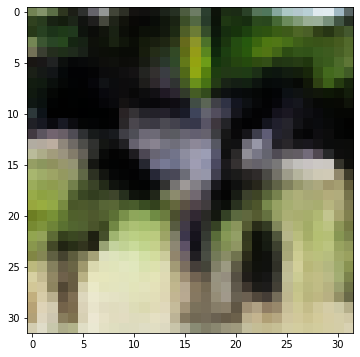

In [39]:
# 로드한 모델이 정상적으로 이미지를 생성하는지 확인한다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것이다.

### 결과

> 생성된 이미지는 눈으로 배경과 대상을 인식할 정도로 출력되었다.

### 7. GAN 훈련 과정 개선하기

> * STEP 6을 진행하면서 생성된 샘플 이미지, 학습 과정 그래프 등을 통해 이전 훈련 과정의 문제점을 분석한다.
> * 모델구조 또는 학습 과정을 개선한 내역과 그 결과(샘플 이미지, 학습 과정 그래프 포함)를 함께 제출한다.

### Case-1) BATCH Size를 256에서 128으로 변경

> * BATCH_SIZE: 128                (모델이 한 번에 학습할 데이터 양)     
> * Adam learning rate: 0.0001     (최적화함수 하이퍼 파라미터)
> * EPOCHS: 200

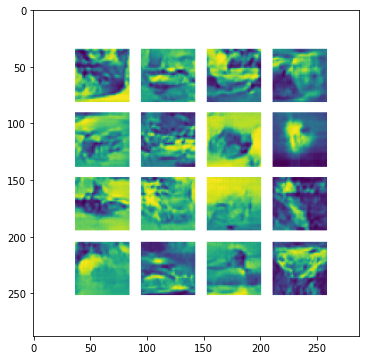

In [41]:
import os
import cv2

result01 = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_0200_iter_390.png'   
result01 = cv2.imread(result01) 
result01 = cv2.cvtColor(result01, cv2.COLOR_BGR2RGB)     
plt.imshow(result01)  
plt.show()

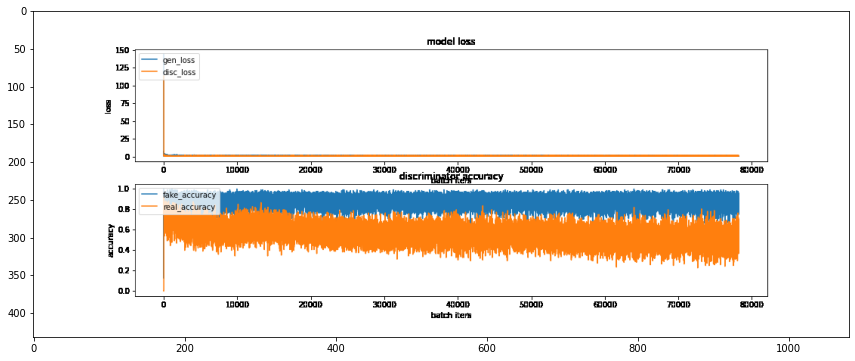

In [42]:
resultg01 = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_history/train_history_0199.png'   
resultg01 = cv2.imread(resultg01) 
resultg01 = cv2.cvtColor(resultg01, cv2.COLOR_BGR2RGB)     
plt.imshow(resultg01)  
plt.show()

### Case-2) 최적화 함수의 학습률 변경

> * BATCH_SIZE: 128                (모델이 한 번에 학습할 데이터 양)     
> * Adam learning rate: 0.0002     (최적화함수 하이퍼 파라미터)
> * EPOCHS: 200

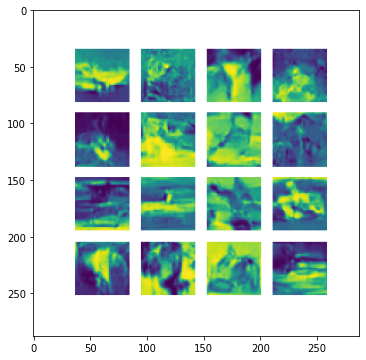

In [43]:
result02 = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/test/generated_samples/sample_epoch_0200_iter_390.png'   
result02 = cv2.imread(result02) 
result02 = cv2.cvtColor(result02, cv2.COLOR_BGR2RGB)     
plt.imshow(result02)  
plt.show()

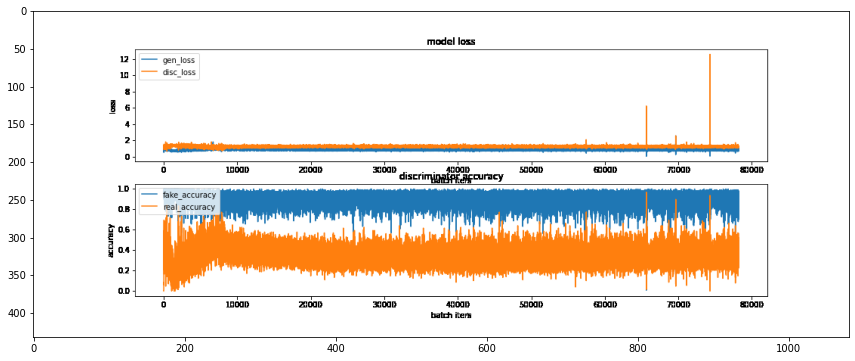

In [44]:
resultg02 = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/test/training_history/train_history_0199.png'   
resultg02 = cv2.imread(resultg02) 
resultg02 = cv2.cvtColor(resultg02, cv2.COLOR_BGR2RGB)     
plt.imshow(resultg02)  
plt.show()

### Case-3) 최적화 함수의 학습률 변경

> * BATCH_SIZE: 128                (모델이 한 번에 학습할 데이터 양)     
> * Adam learning rate: 0.0002     (최적화함수 하이퍼 파라미터)
> * EPOCHS: 1200

'EPOCHS=1200'을 설치하려 하였으나, 커널이 200회를 넘으면 죽었다. tensorflow GPU가 작동하지 않는 것 같아, 해결을 시도하였으나 마무리가 되지 않아 다음 기회에 시도한다.

## 결과

> real accuracy와 fake accuracy는 초반에 1.0에 가깝다가 서서히 낮아져서 둘 다 0.5에 가까워지는 것이 이상적이다. fake accuracy가 1.0에 더 가깝다면 아직은 생성자가 판별자를 충분히 잘 속이지 못하고 있다는 뜻이다.
>
> 최적화함수의 하이퍼 파라미터를 조정한 case-2가 case-1에 비해 좋은 결과를 출력하였다. case-2는 case-1에 비해 1에 가깝던 fake accuracy의 분산이 0.5에도 미치도록 분산이 커졌다. 또한 real accuracy도 case-1은 0.4에서 0.8, case-2는 0.2에서 0.6사이의 분산으로 이동하였다.


## 총평

> GAN의 작동 원리에 대해 배우고, 직접 실습해 볼 수 있는 좋은 기회였다. 다만, GPU 작동 문제가 해결되지 않아, 'EPOCHS=1200'의 결과를 출력하지 못한 점이 아쉬움으로 남는다.
>
>다음의 참고 자료를 통해 EPOCHS의 높은 값이 좋은 결과를 늘 보장하는 것은 아니며, GAN의 학습 결과 생성된 이미지를 확인하며 마무리하였다.

**참고 자료** 

https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/